In [170]:
# Import required libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRFRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
pd.set_option("future.no_silent_downcasting", True)

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (C:\Users\joel.sarkisyan\AppData\Local\anaconda3\Lib\site-packages\sklearn\inspection\__init__.py)

In [123]:
# Read the dataset
dataset = pd.read_csv('esg-dataset.csv')

In [153]:
# Preview the dataset
dataset.head()

,Company,EGroup1,EGroup2,EGroup3,EGroup4,Ggroup,SGroup1,SGroup2,SGroup3,SGroup4,Controversy Level,Controversy Score,ESG_Loan Approval,A,B,C
0,1,3,3,3,3,3,3,3,0,D,Moderate Controversy Level,2.0,2,7,0,0
1,2,3,3,3,3,3,3,3,3,A,Low Controversy Level,1.0,2,9,0,0
2,3,3,3,3,3,3,3,3,3,A,Low Controversy Level,1.0,2,9,0,0
3,4,2,2,3,3,3,1,3,3,A,None Controversy Level,2.0,2,6,2,1
4,5,2,2,0,3,3,3,3,3,C,Low Controversy Level,1.0,2,5,2,1


In [130]:
scores = ["EGroup1", "EGroup2", "EGroup3", "EGroup4", "Ggroup", "SGroup1", "SGroup2", "SGroup3", "SGroup4"]
dataset["A"] = dataset[dataset.loc[:,scores] == "A"].count(axis=1)
dataset["B"] = dataset[dataset.loc[:,scores] == "B"].count(axis=1)
dataset["C"] = dataset[dataset.loc[:,scores] == "C"].count(axis=1)


dataset["Controversy Score"] = dataset["Controversy Score"].fillna((dataset['Controversy Score'].median()))


mapping1 = {'High': 2, 'Medium': 1, 'Low': 0}
mapping2 = {'A' : 3, 'B' : 2, 'C' : 1, 'D' : 0}

dataset["ESG_Loan Approval"] = dataset["ESG_Loan Approval"].map(mapping1)
for col in dataset.columns[1:9]:
    dataset[col] = dataset[col].map(mapping2)

In [131]:
# Check the column names
dataset.columns

Index(['Company', 'EGroup1', 'EGroup2', 'EGroup3', 'EGroup4', 'Ggroup',
       'SGroup1', 'SGroup2', 'SGroup3', 'SGroup4', 'Controversy Level',
       'Controversy Score', 'ESG_Loan Approval', 'A', 'B', 'C'],
      dtype='object')

In [154]:
## Selecting the features and target variable
# Controversy Level and Controversy Score reflect the same infomation (highly correlated). So, we can drop one of them.
interested_features = ['EGroup1',
                       'EGroup2',
                       'EGroup3',
                       'EGroup4',
                       'Ggroup',
                       'SGroup1',
                       'SGroup2',
                       'SGroup3',
                       'SGroup4',
                       'Controversy Score','A', 'B', 'C']
target_var = 'ESG_Loan Approval'

## Exploratory Data Analysis

In [155]:
dataset_copy = dataset.copy()

C:\Users\joel.sarkisyan\AppData\Local\Temp\ipykernel_21336\3434623401.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 2, i+1)


ValueError: num must be an integer with 1 <= num <= 10, not 11

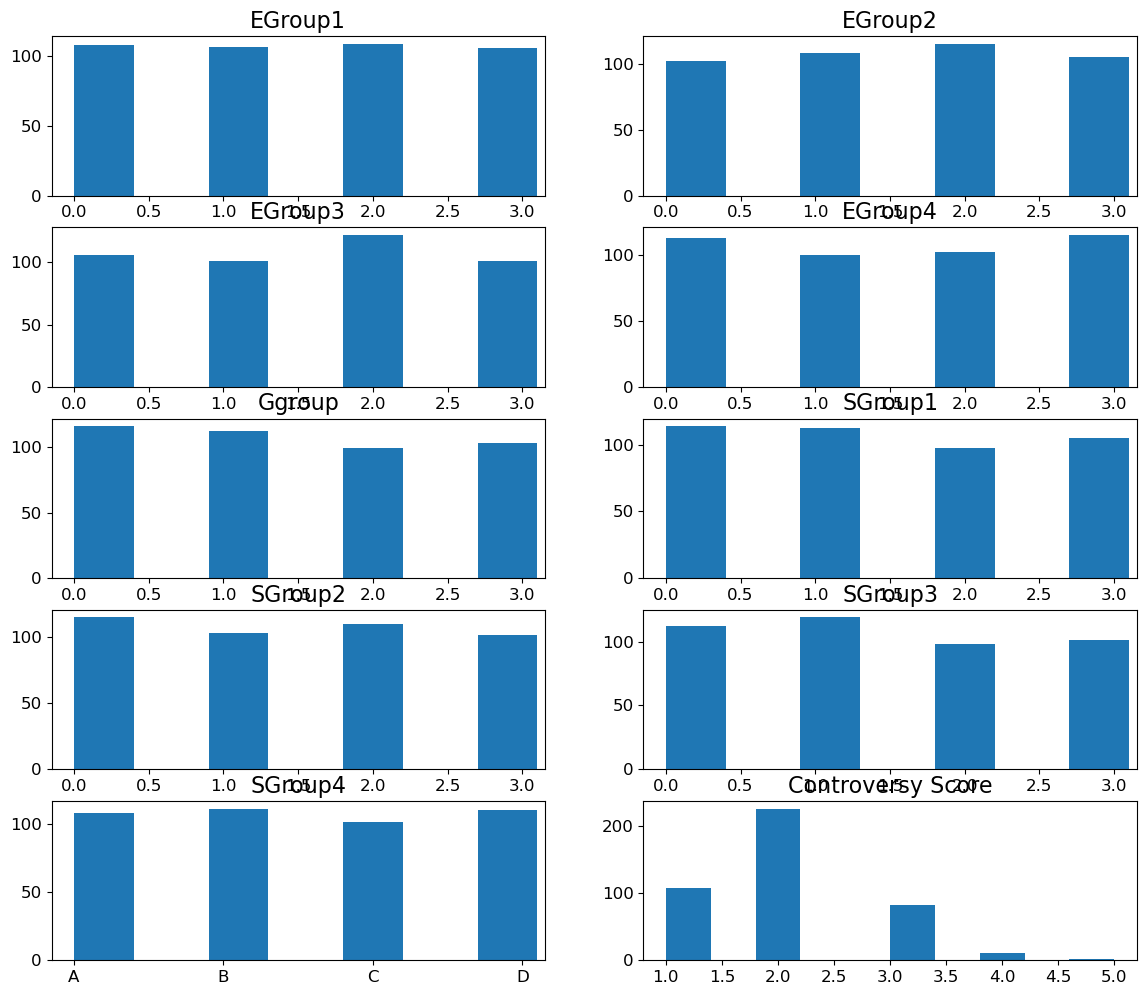

In [156]:
# Feature Distributions
plt.subplots(figsize=(14, 12))
for i, feature in enumerate(interested_features):
    ax = plt.subplot(5, 2, i+1)
    ax.hist(dataset_copy[feature].sort_values(), width = 0.4)
    ax.set_title(feature)
plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure()
dataset["ESG_Loan Approval"].hist(density = True)
plt.title("Distribution of Target Variable")
plt.tight_layout()
plt.show()

In [ ]:
# Distribution of features grouping by target variable
plt.subplots(figsize=(14, 12))
for i, feature in enumerate(interested_features):
    plt.subplot(5, 2, i+1)
    dataset_copy = dataset_copy.sort_values(feature)
    sns.countplot(x=feature, data=dataset_copy, hue=target_var)
plt.suptitle('Feature Distributions Grouped by Target Variable')
plt.tight_layout()
plt.show()

In [ ]:
# transform str to int for correlation analysis
mapping = {"A": int(4), "B": int(3), "C": int(2), "D": int(1)}
for feature in interested_features:
    dataset_copy[feature] = dataset_copy[feature].replace(mapping)
target_map = {"High": int(2), "Medium": int(1), "Low": int(0)}
dataset_copy["ESG_Loan Approval"]=dataset_copy["ESG_Loan Approval"].replace(target_map)

In [ ]:
# exclude missing values for now
dataset_copy = dataset_copy.dropna()
# drop out the Contraversy Level column
dataset_copy = dataset_copy.drop(["Controversy Level"], axis=1)

In [ ]:
# Kenall Rank Correlation Matrix
corr = dataset_copy.corr(method='kendall')
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Missing Value Detection and Filling

In [157]:
features = dataset[interested_features]
target = dataset[target_var]

In [158]:
# Numebr of sissing value in features
features.isnull().sum()

EGroup1              0
EGroup2              0
EGroup3              0
EGroup4              0
Ggroup               0
SGroup1              0
SGroup2              0
SGroup3              0
SGroup4              0
Controversy Score    0
A                    0
B                    0
C                    0
dtype: int64

In [159]:
# Fill the controversy Score with the mode
mode = features["Controversy Score"].mode()[0]
features.loc[:,"Controversy Score"] = features["Controversy Score"].replace(np.nan, mode)

In [160]:
# Check the missing values again
features.isnull().sum()

EGroup1              0
EGroup2              0
EGroup3              0
EGroup4              0
Ggroup               0
SGroup1              0
SGroup2              0
SGroup3              0
SGroup4              0
Controversy Score    0
A                    0
B                    0
C                    0
dtype: int64

## Data Transformation

In [161]:
features

,EGroup1,EGroup2,EGroup3,EGroup4,Ggroup,SGroup1,SGroup2,SGroup3,SGroup4,Controversy Score,A,B,C
0,3,3,3,3,3,3,3,0,D,2.0,7,0,0
1,3,3,3,3,3,3,3,3,A,1.0,9,0,0
2,3,3,3,3,3,3,3,3,A,1.0,9,0,0
3,2,2,3,3,3,1,3,3,A,2.0,6,2,1
4,2,2,0,3,3,3,3,3,C,1.0,5,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,0,0,0,0,0,0,0,0,C,2.0,0,0,1
426,1,1,3,0,0,2,2,0,A,4.0,2,2,2
427,0,0,1,3,0,0,0,0,A,3.0,2,0,1
428,0,0,0,0,1,0,1,0,C,3.0,0,0,3


In [162]:
# Encode the categorical variables using one-hot encoding
cat_featrues = ['EGroup1',
                'EGroup2',
                'EGroup3',
                'EGroup4',
                'Ggroup',
                'SGroup1',
                'SGroup2',
                'SGroup3',
                'SGroup4']
# features = pd.get_dummies(features, columns=cat_featrues, drop_first=False, dtype = int)
cat_mapping = {"A": int(3), "B": int(2), "C": int(1), "D": int(0)}
for feature in cat_featrues:
    features.loc[:,feature] = features[feature].replace(cat_mapping)
features = features.astype(int)

In [163]:
# Transform the target variable from categorical to numerical
target_map = {"High": int(2), "Medium": int(1), "Low": int(0)}
target = target.replace(target_map).astype(int)

## Modelling

In [164]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [87]:
# Baseline model: Logistic Regression
logis_classifier = LogisticRegression()
param_grid = {
    'C': [5, 2, 1, 0.5, 0.1, 0.05],
    'class_weight': ['balanced'],
    'penalty': ['none', 'l2']
}
grid_search = GridSearchCV(estimator=logis_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_xgb_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 12 candidates, totalling 96 fits
{'C': 2, 'class_weight': 'balanced', 'penalty': 'l2'}


In [81]:
pred_train_logist = best_xgb_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_logist)
prec_train = precision_score(y_train,pred_train_logist, average='macro')
recall_train = recall_score(y_train,pred_train_logist, average='macro')
f1_train = f1_score(y_train,pred_train_logist, average='macro')

pred_test_logist = best_xgb_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_logist)
prec_test = precision_score(y_test,pred_test_logist, average='macro')
recall_test = recall_score(y_test,pred_test_logist, average='macro')
f1_test = f1_score(y_test,pred_test_logist, average='macro')

In [82]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.7529
Train Precision: 0.7081
Train recall: 0.7784
Train f1-score: 0.7271
**********Test Phase**********
Test Acc: 0.7674
Test Precision: 0.7267
Test recall: 0.7184
Test f1-score: 0.7222


# Random forest 

In [165]:
# Create a random forest regressor
rf_classifier = RandomForestClassifier()
# grid search for hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [2, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10, 20, 40],
    'max_features' : ["auto", "sqrt", "log2"],
    'class_weight': ['balanced']
}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_rf_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 375 candidates, totalling 3000 fits
{'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 100}


C:\Users\joel.sarkisyan\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1000 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
757 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\joel.sarkisyan\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\joel.sarkisyan\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\joel.sarkisyan\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _valida

In [84]:
pred_train_rf = best_rf_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_rf)
prec_train = precision_score(y_train,pred_train_rf, average='macro')
recall_train = recall_score(y_train,pred_train_rf, average='macro')
f1_train = f1_score(y_train,pred_train_rf, average='macro')

pred_test_rf = best_rf_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_rf)
prec_test = precision_score(y_test,pred_test_rf, average='macro')
recall_test = recall_score(y_test,pred_test_rf, average='macro')
f1_test = f1_score(y_test,pred_test_rf, average='macro')

In [74]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.9483
Train Precision: 0.9459
Train recall: 0.9553
Train f1-score: 0.9503
**********Test Phase**********
Test Acc: 0.7907
Test Precision: 0.8021
Test recall: 0.7756
Test f1-score: 0.7847


In [53]:
xgb_classifier = xgb.XGBClassifier()
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 5, 7, 10, 15],
    'subsample': [1, 0.95, 0.75, 0.5, 0.35],
    'lambda': [1.5, 1, 0.75, 0.5, 0.2],
    'alpha': [5, 2, 1, 0.5],
    'eta': [0.05, 0.1, 0.3],
    'max_delta_step': [0, 1, 2, 5]
}
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=8, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print(best_params)
# Get the best model
best_xgb_classifier = grid_search.best_estimator_

Fitting 8 folds for each of 24000 candidates, totalling 192000 fits


KeyboardInterrupt: 

In [63]:
pred_train_xgbm = best_xgb_classifier.predict(X_train)
acc_train = accuracy_score(y_train, pred_train_xgbm)
prec_train = precision_score(y_train,pred_train_xgbm, average='macro')
recall_train = recall_score(y_train,pred_train_xgbm, average='macro')
f1_train = f1_score(y_train,pred_train_xgbm, average='macro')

pred_test_xgbm = best_xgb_classifier.predict(X_test)
acc_test = accuracy_score(y_test, pred_test_xgbm)
prec_test = precision_score(y_test,pred_test_xgbm, average='macro')
recall_test = recall_score(y_test,pred_test_xgbm, average='macro')
f1_test = f1_score(y_test,pred_test_xgbm, average='macro')

In [64]:
print("*"*10 + "Training Phase" + "*"*10)
print("Train Acc: %.4f" %(acc_train))
print("Train Precision: %.4f" %(prec_train))
print("Train recall: %.4f" %(recall_train))
print("Train f1-score: %.4f" %(f1_train)) 

print("*"*10 + "Test Phase" + "*"*10)
print("Test Acc: %.4f" %(acc_test))
print("Test Precision: %.4f" %(prec_test))
print("Test recall: %.4f" %(recall_test))
print("Test f1-score: %.4f" %(f1_test)) 

**********Training Phase**********
Train Acc: 0.8579
Train Precision: 0.8600
Train recall: 0.7862
Train f1-score: 0.8122
**********Test Phase**********
Test Acc: 0.7442
Test Precision: 0.7421
Test recall: 0.6762
Test f1-score: 0.6935


# Global interpretation

In [191]:
%matplotlib qt5
#%% Global Interpretation
# Feature Importance (Criterion: MSE)
rf_fi = best_rf_classifier.feature_importances_
#print("*"*50)
print("Random Forest Feature Importance:")
for i in range(gbm_fi.shape[0]):
    print("{}: {:.6f}".format(X_train.columns[i], gbm_fi[i]))

w_list = rf_fi
feature_names = [X_train.columns[i] for i in range(len(w_list))]
name, w_list = zip(*sorted(zip(feature_names, list(w_list)),key=lambda x: x[1], reverse=False))
plt.figure()
plt.title("Feature Importance for Random Forest",fontsize=16)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = "large"
plt.rcParams["ytick.labelsize"] = "large"
plt.barh(name, w_list,color="royalblue")
plt.grid(True, axis="x")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
for i in range(len(weight)):
    plt.text(weight[i]+0.03, name[i], "%.4f" % weight[i], ha='center', fontsize=12)

Random Forest Feature Importance:
EGroup1: 0.263428
EGroup2: 0.094055
EGroup3: 0.104388
EGroup4: 0.059457
Ggroup: 0.069095
SGroup1: 0.061267
SGroup2: 0.104310
SGroup3: 0.090591
SGroup4: 0.077851
Controversy Score: 0.075557


In [111]:
w_list

(0.0594566675312935,
 0.061267376272436884,
 0.06909486836233238,
 0.07555652305054686,
 0.07785129510845404,
 0.0905914458878068,
 0.09405546108627315,
 0.10430954508302386,
 0.10438834840591824,
 0.2634284692119144)

# PDP

In [194]:
%matplotlib qt5
features = [i for i in range(6)]  # Replace with the indices or names of the features you want to inspect

# Generate the PDP
fig, ax = plt.subplots()
PartialDependenceDisplay.from_estimator(best_rf_classifier, X_train, features, ax=ax, target = 2)

# Show the plot
plt.tight_layout()
plt.show()

In [192]:
label_map = {0: 'Low', 1: 'Medium', 2: 'High'}

plt.subplots(figsize=(16, 4))
ax1 = plt.subplot(1, 3, 1)
confMat=confusion_matrix(y_test, pred_test_logist)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax1=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax1.set_title('Confusion Matrix on Test Set (Logistic Regression)', fontsize=12)
ax1.set_xlabel('Predicted Class', fontsize=10)
ax1.set_ylabel('True Class', fontsize=10)

ax2 = plt.subplot(1, 3, 2)
confMat=confusion_matrix(y_test, pred_test_rf)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax2=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax2.set_title('Confusion Matrix on Test Set (Random Forest)', fontsize=12)
ax2.set_xlabel('Predicted Class', fontsize=10)
ax2.set_ylabel('True Class', fontsize=10)

ax3 = plt.subplot(1, 3, 3)
confMat=confusion_matrix(y_test, pred_test_xgbm)
confMat=pd.DataFrame(confMat)
confMat=confMat.rename(index=label_map, columns= label_map)
ax3=sns.heatmap(confMat, fmt='d',cmap='Greys',annot=True)
ax3.set_title('Confusion Matrix on Test Set (XGBoost)', fontsize=12)
ax3.set_xlabel('Predicted Class', fontsize=10)
ax3.set_ylabel('True Class', fontsize=10)

plt.show()

C:\Users\joel.sarkisyan\AppData\Local\Temp\ipykernel_21336\870307692.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 3, 1)


NameError: name 'pred_test_xgbm' is not defined